In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.1f' % x)

In [2]:
geo_df = pd.read_csv('../data/Longitud_Latitud.csv')
geo_df.columns = ['no', 'sub_area', 'lon', 'lat']
coords = geo_df.as_matrix(columns=['lat', 'lon'])

df = pd.read_csv('../data/clean_train_only_complete_cols_chase.csv', index_col='id',parse_dates=['timestamp'])
test = pd.read_csv('../data/clean_test_only_complete_cols_chase.csv', index_col='id',parse_dates=['timestamp'])

# cols = ['price_doc','timestamp','sub_area','kremlin_km','full_sq','price_full']
# df = df[cols]

In [3]:
# http://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
def getClusters(coords,km_radius):
    kms_per_radian = 6371.0088
    epsilon = km_radius / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    return db.labels_


In [4]:
avg_std = []
cnts = []
kms = np.linspace(0.5,10,20)
for k in kms:
    x = geo_df.copy()
    x['new_group_id'] = getClusters(coords,k)
    
    temp = pd.merge(df,x[['sub_area','new_group_id']], how="left", on="sub_area").groupby('new_group_id')
    avg_std.append(np.nanmean(temp.price_full.std()))
    cnts.append(x.new_group_id.nunique())
#     print temp.groupby('new_group_id').price_full.var

#     avg_var.append(np.nanmean(df.groupby('new_group_id').price_full.var))
cluster_summary = pd.DataFrame({'km_radius': kms, 'avg_std': avg_std, 'num_clusters':cnts})

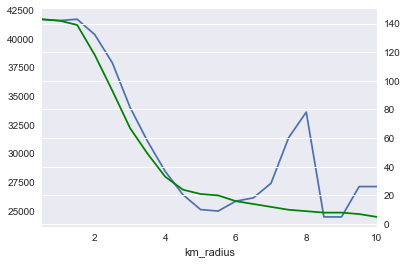

In [5]:
cluster_summary.set_index('km_radius').avg_std.plot()
cluster_summary.set_index('km_radius').num_clusters.plot(secondary_y=True, style='g')

,no,sub_area,lon,lat,new_group_id
0,1,Babushkinskoe,55.9,37.7,0
1,2,Ljublino,55.7,37.8,0
2,3,Hovrino,55.9,37.5,0
3,4,Tverskoe,55.8,37.6,0
4,5,Jakimanka,55.7,37.6,0


In [16]:
geo_df['new_group_id'] = getClusters(coords,5)
geo_df.new_group_id = geo_df.new_group_id.astype(object)

In [17]:
# this is just to check to see if new_group is already in the df
if 'new_group_id' in df.columns.tolist():
    df.drop('new_group_id',axis=1,inplace=True)
df = pd.merge(df,geo_df[['sub_area','new_group_id']],
              how="left", on="sub_area").reset_index(drop=True).set_index(df.index)

In [18]:
df.groupby('new_group_id').count()

,timestamp,full_sq,life_sq,floor,max_floor,kitch_sq,product_type,sub_area,area_m,raion_popul,...,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,Unnamed: 0,okurg_district,price_full,life_to_full,kitch_to_life,log_price
new_group_id,,,,,,,,,,,,,,,,,,,,,
0,21874,21874,21874,21874,21874,21874,21874,21874,21874,21874,...,21874,21874,21874,21874,21874,21874,21874,21874,21874,21874
1,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
2,133,133,133,133,133,133,133,133,133,133,...,133,133,133,133,133,133,133,133,133,133
3,1464,1464,1464,1464,1464,1464,1464,1464,1464,1464,...,1464,1464,1464,1464,1464,1464,1464,1464,1464,1464
5,1570,1570,1570,1570,1570,1570,1570,1570,1570,1570,...,1570,1570,1570,1570,1570,1570,1570,1570,1570,1570
6,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,752,752,752,752,752,752,752,752,752,752,...,752,752,752,752,752,752,752,752,752,752
9,21,21,21,21,21,21,21,21,21,21,...,21,21,21,21,21,21,21,21,21,21


In [11]:
df['log_price'] = np.log(df.price_doc+1)

In [14]:
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score

ols = linear_model.LinearRegression()

# cols to drop
# drop_cols = ['timestamp','price_doc','nominal_index','adj_price_doc','price_full','log_price','price_full']
cols = ['full_sq','new_group_id','log_price']
lm_data = df[cols]

df_obj = lm_data.select_dtypes(include=['object'])
df_num = lm_data.select_dtypes(exclude=['object'])


dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)

x_train = df_all.drop('log_price',axis=1)

y_train = df_all.log_price

# x_test = df_all.loc[test_index,:]

ols.fit(x_train,y_train)
print('R^2: %.2f' % ols.score(x_train, y_train))
# df.log_price

R^2: 0.57


In [9]:
dfg = df.groupby('new_group_id')

In [10]:
dfg_price_full = dfg.price_full.median().sort_values()
# f_oneway(dfg.price_full.get_group(0),dfg.price_full.get_group(1))

In [432]:
import statsmodels.formula.api as sm

all_columns = "+".join(df_all.columns[1:-1])

model = sm.ols(formula ='price_doc ~ ' + all_columns, data = df_all)
fitted = model.fit()
# print fitted.summary()

SyntaxError: invalid syntax (<unknown>, line 1)

In [433]:
from sklearn.feature_selection import f_regression

In [434]:
df['price_class'] = pd.qcut(df.price_full, 5, labels=range(5,0,-1))

Index([u'timestamp', u'full_sq', u'life_sq', u'floor', u'max_floor',
       u'kitch_sq', u'product_type', u'sub_area', u'area_m', u'raion_popul',
       ...
       u'church_count_5000', u'mosque_count_5000', u'leisure_count_5000',
       u'sport_count_5000', u'market_count_5000', u'price_doc',
       u'okurg_district', u'price_full', u'new_group_id', u'price_class'],
      dtype='object', length=248)

In [458]:
labs = {k:v for (k,v) in zip(range(0,5),['no data','poor','satisfactory','good', 'excellent'])}
labs

{0: 'no data', 1: 'poor', 2: 'satisfactory', 3: 'good', 4: 'excellent'}

In [468]:
drop_cols = ['price_class','price_doc','price_full']

df_obj = df.drop(drop_cols,axis=1).select_dtypes(include=['object'])
df_num = df.drop(drop_cols,axis=1).select_dtypes(exclude=['object'])


dummies = pd.get_dummies(df_obj)
df_all = pd.concat([df_num,dummies],axis=1)


f_regression(df_all,df.price_class)

TypeError: float() argument must be a string or a number

In [21]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)


In [28]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
rs = rep_points.apply(lambda row: df[(df['lat']==row['lat']) & (df['lon']==row['lon'])].iloc[0], axis=1)

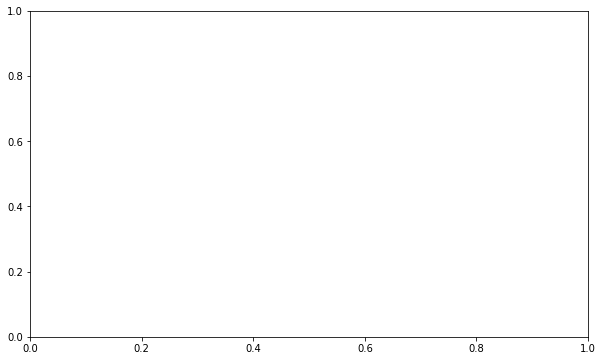

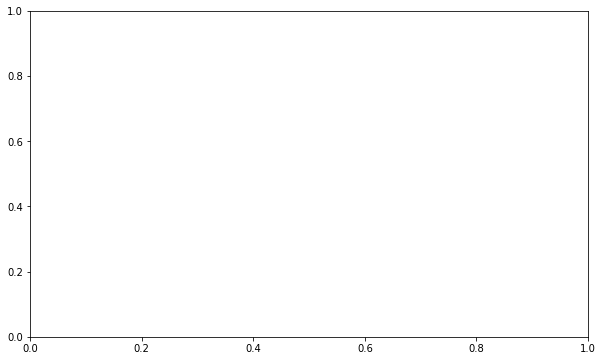

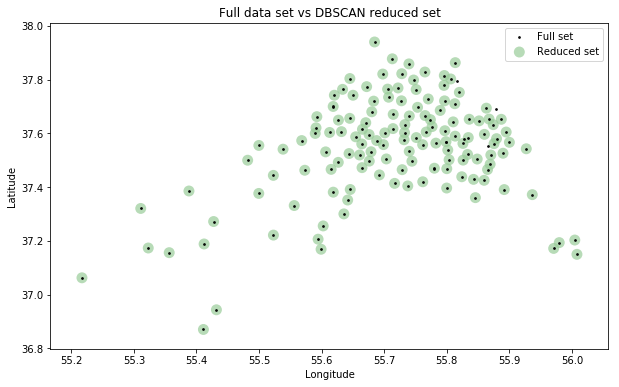

In [29]:
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['lon'], rs['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['lon'], df['lat'], c='k', alpha=0.9, s=3)
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()